In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import vectorbtpro as vbt
import warnings
import plotly.express as px
import plotly.graph_objects as go
warnings.filterwarnings('ignore')

from utils.db_utils import QUERY
from analysis.stats import run_monte_carlo_simulation, run_block_bootstrap, calculate_block_bootstrap_performance_metrics
from helper import *


In [22]:
btc = QUERY(
    """
    SELECT 
        time_period_end,
        close_spot AS close,
    FROM market_data.ml_features
    WHERE
        asset_id_base = 'BTC' AND
        asset_id_quote = 'USDT' AND
        exchange_id = 'BINANCE'
    ORDER BY time_period_end
    """
)
eth = QUERY(
    """
    SELECT 
        time_period_end,
        close_spot AS close,
    FROM market_data.ml_features
    WHERE
        asset_id_base = 'ETH' AND
        asset_id_quote = 'USDT' AND
        exchange_id = 'BINANCE'
    ORDER BY time_period_end
    """
)
benchmark = pd.merge(
    btc,
    eth,
    on='time_period_end',
    suffixes=('_BTC', '_ETH')
)
benchmark['equity'] = 10000 * (0.5 * benchmark['close_BTC'].pct_change() + 0.5 * benchmark['close_ETH'].pct_change() + 1).cumprod().fillna(1)
benchmark['returns'] = benchmark['equity'].pct_change().fillna(0)
benchmark = benchmark.drop(['close_BTC', 'close_ETH'], axis=1).set_index('time_period_end')
benchmark

,equity,returns
time_period_end,,
2017-08-18,10000.000000,0.000000
2017-08-19,9647.374936,-0.035263
2017-08-20,9647.341425,-0.000003
2017-08-21,9700.591990,0.005520
2017-08-22,9993.048097,0.030148
...,...,...
2025-04-28,152009.866602,-0.011891
2025-04-29,153151.595877,0.007511
2025-04-30,152638.917938,-0.003348


In [23]:
symbol_ids = QUERY(
    """
    SELECT DISTINCT symbol_id
    FROM backtest.backtest_results
    ORDER BY symbol_id
    """
)
symbol_ids

,symbol_id
0,PORTFOLIO_UNIVERSE


In [24]:
strats = QUERY(
    """
    SELECT DISTINCT strat
    FROM backtest.backtest_results
    """
)
strats

,strat
0,MACrossoverStrategy
1,CrossSectionalAlphaRankStrategy
2,PortfolioMLStrategy (vt)
3,PortfolioMLStrategy


In [25]:
symbol_id = 'PORTFOLIO_UNIVERSE'
strat = 'PortfolioMLStrategy (vt)'

In [26]:
all_metrics = QUERY(
    f"""
    SELECT *
    FROM backtest.backtest_results
    WHERE
        strat = '{strat}'
    """
)


In [27]:
trades_data = QUERY(
    f"""
    SELECT *
    FROM backtest.backtest_trades
    WHERE
        symbol_id = '{symbol_id}' AND
        strat = '{strat}'
    """
)

In [28]:
strategy_equity_curve = QUERY(
    f"""
    SELECT *
    FROM backtest.backtest_equity_curves
    WHERE
        symbol_id = '{symbol_id}' AND
        strat = '{strat}'
    ORDER BY date
    """
)

In [29]:
merged = pd.merge(
    strategy_equity_curve,
    benchmark,
    left_on='date',
    right_on='time_period_end',
    how='inner',
    suffixes=('_strategy', '_benchmark')
)

In [30]:
merged['strategy_return'] = merged['equity_strategy'].pct_change().fillna(0)
merged['benchmark_return'] = merged['equity_benchmark'].pct_change().fillna(0)

# Calculate rolling alpha and beta
merged['rolling_beta'] = merged['strategy_return'].ewm(span=7).cov(merged['benchmark_return']) / merged['benchmark_return'].ewm(span=7).var()
merged['rolling_alpha'] = merged['strategy_return'].ewm(span=7).mean() - merged['rolling_beta'] * merged['benchmark_return'].ewm(span=7).mean()

In [31]:
# Plot the rolling beta of the strategy as a lineplot using Plotly as separate figures
fig = go.Figure()
fig.add_trace(go.Scatter(x=merged['date'], y=merged['rolling_beta'], mode='lines', name='Rolling Beta'))
fig.update_layout(
    title='Rolling OOS. Beta of the Strategy',
    xaxis_title='Date',
    yaxis_title='30-Day Beta',
    legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
    # Dark mode
    template='plotly_dark',
)
# Show the plot
fig.show()

# Plot the rolling alpha of the strategy as a lineplot using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=merged['date'], y=merged['rolling_alpha'], mode='lines', name='Rolling Alpha'))
fig.update_layout(
    title='Rolling OOS. Alpha of the Strategy',
    xaxis_title='Date',
    yaxis_title='30-Day Alpha',
    legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
    # Dark mode
    template='plotly_dark',
)
# Show the plot
fig.show()


In [32]:
merged['resid_return'] = merged['strategy_return'] - merged['rolling_beta'].shift(1) * merged['benchmark_return']
merged['hedged_equity'] = 10000 * (1 + merged['resid_return']).cumprod().fillna(1)
hedged_equity_curve = merged[['date', 'hedged_equity']]
hedged_equity_curve = hedged_equity_curve.rename(columns={'hedged_equity': 'equity'})

In [33]:
# Hedged equity curve alpha and beta
hedged_equity_curve['rolling_beta'] = hedged_equity_curve['equity'].pct_change().ewm(span=7).cov(merged['benchmark_return']) / merged['benchmark_return'].ewm(span=7).var()
hedged_equity_curve['rolling_alpha'] = hedged_equity_curve['equity'].pct_change().ewm(span=7).mean() - hedged_equity_curve['rolling_beta'] * merged['benchmark_return'].ewm(span=7).mean()

In [34]:
# Plot the rolling beta of the strategy as a lineplot using Plotly as separate figures
fig = go.Figure()
fig.add_trace(go.Scatter(x=hedged_equity_curve['date'], y=hedged_equity_curve['rolling_beta'], mode='lines', name='Rolling Beta'))
fig.update_layout(
    title='Rolling OOS. Beta of the Beta-Hedged Strategy',
    xaxis_title='Date',
    yaxis_title='30-Day Beta',
    legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
    # Dark mode
    template='plotly_dark',
)
# Show the plot
fig.show()

# Plot the rolling alpha of the strategy as a lineplot using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=hedged_equity_curve['date'], y=hedged_equity_curve['rolling_alpha'], mode='lines', name='Rolling Alpha'))
fig.update_layout(
    title='Rolling OOS. Alpha of the Beta-Hedged Strategy',
    xaxis_title='Date',
    yaxis_title='30-Day Alpha',
    legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
    # Dark mode
    template='plotly_dark',
)
# Show the plot
fig.show()


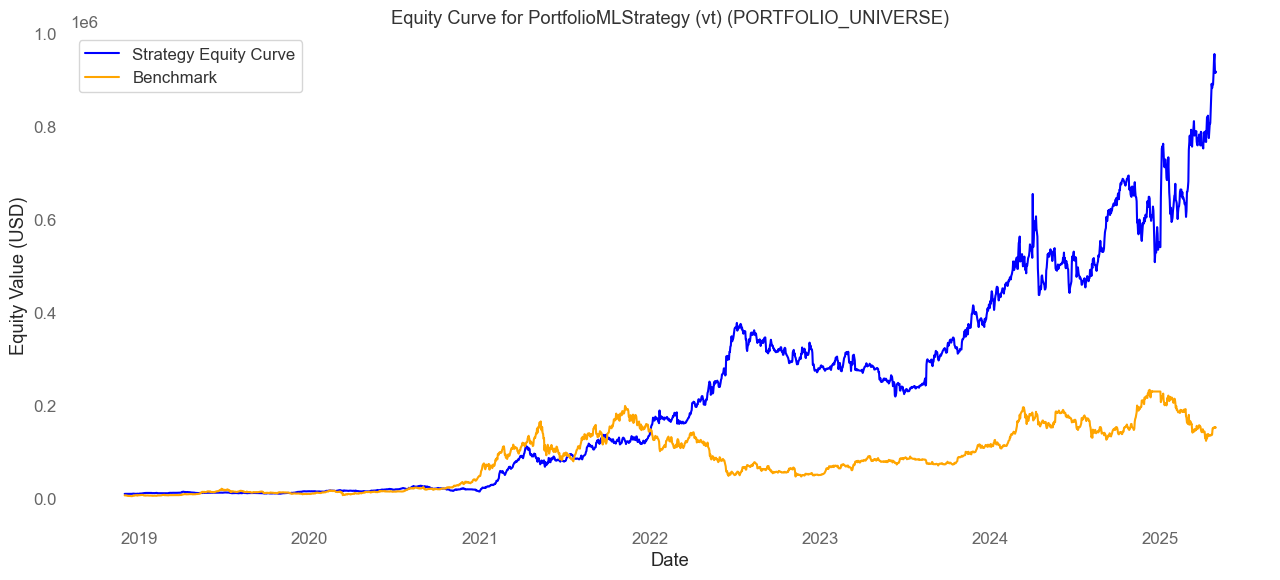

In [35]:
plot_strategy_equity_curve(benchmark, hedged_equity_curve, trades_data, strat, symbol_id)

In [36]:
# monte_carlo_metrics = run_monte_carlo_simulation(trades_data, strategy_equity_curve, 100_000)

In [37]:
N = 1_000_000
bb = run_block_bootstrap(hedged_equity_curve, N)
bb_metrics = calculate_block_bootstrap_performance_metrics(bb, hedged_equity_curve['returns'].values)

Probability of Sharpe Ratio > 0: 1.00
Probability of Sharpe Ratio > 1: 0.94

Probability of Sortino Ratio > 0: 1.00
Probability of Sortino Ratio > 1: 0.99

Probability of Calmar Ratio > 0: 1.00
Probability of Calmar Ratio > 1: 0.90

Mean Sharpe Ratio: 1.62
Mean Sortino Ratio: 2.37
Mean Calmar Ratio: 2.44

99% Confidence Interval for Sharpe Ratio: [0.61116656 2.70167994]
99% Confidence Interval for Sortino Ratio: [0.82795883 4.27588235]
99% Confidence Interval for Calmar Ratio: [0.31626166 7.41290698]


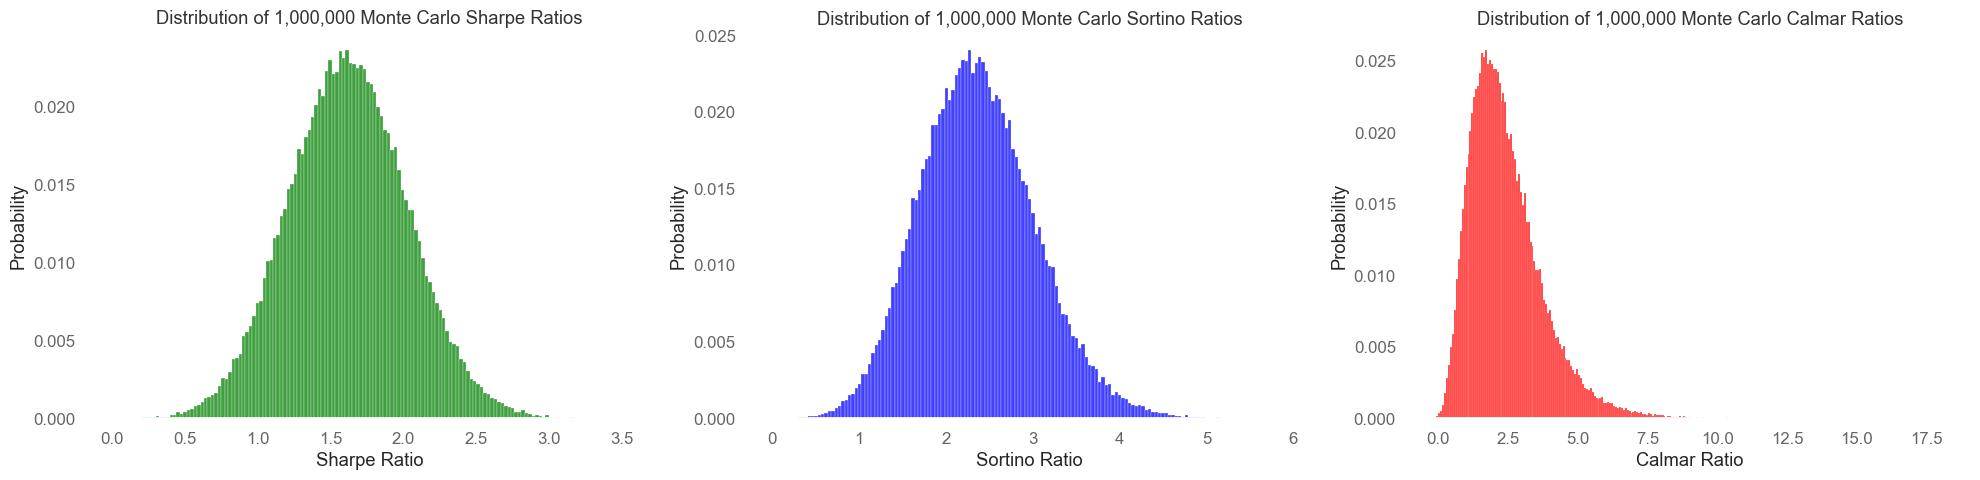

In [38]:
plot_bootstrapped_sharpe_sortino_calmar_ratios(monte_carlo_risk_metrics = bb_metrics, N = N)

Median Alpha: 0.0022
Median Beta: -0.0002

99% Confidence Interval for Alpha: [0.00081075 0.00387917]
99% Confidence Interval for Beta: [-0.05387448  0.05591293]


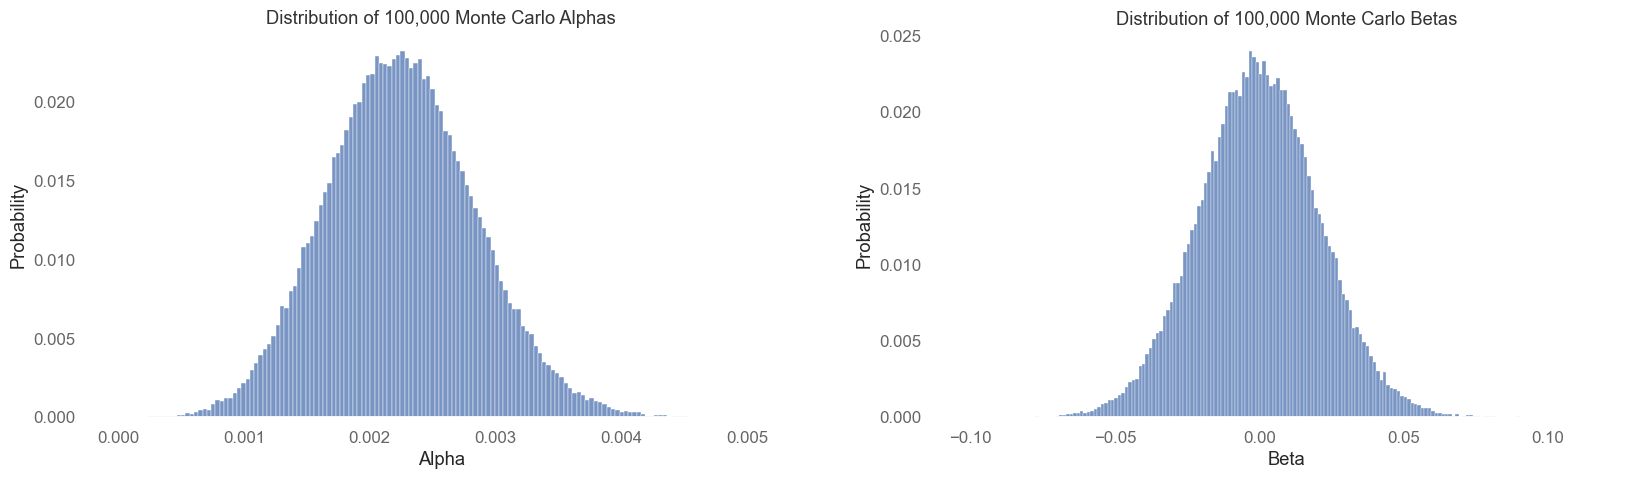

In [43]:
plot_bootstrapped_alpha_beta(monte_carlo_risk_metrics = bb_metrics, N = N)

Risk of Ruin: 1.00

Mean Avg. Drawdown: -14.26%
Mean Max Drawdown: -46.31%

99% Confidence Interval for Avg. Drawdown: [-31.9655669   -7.66912872]
99% Confidence Interval for Max Drawdown: [-74.04507965 -28.68360894]


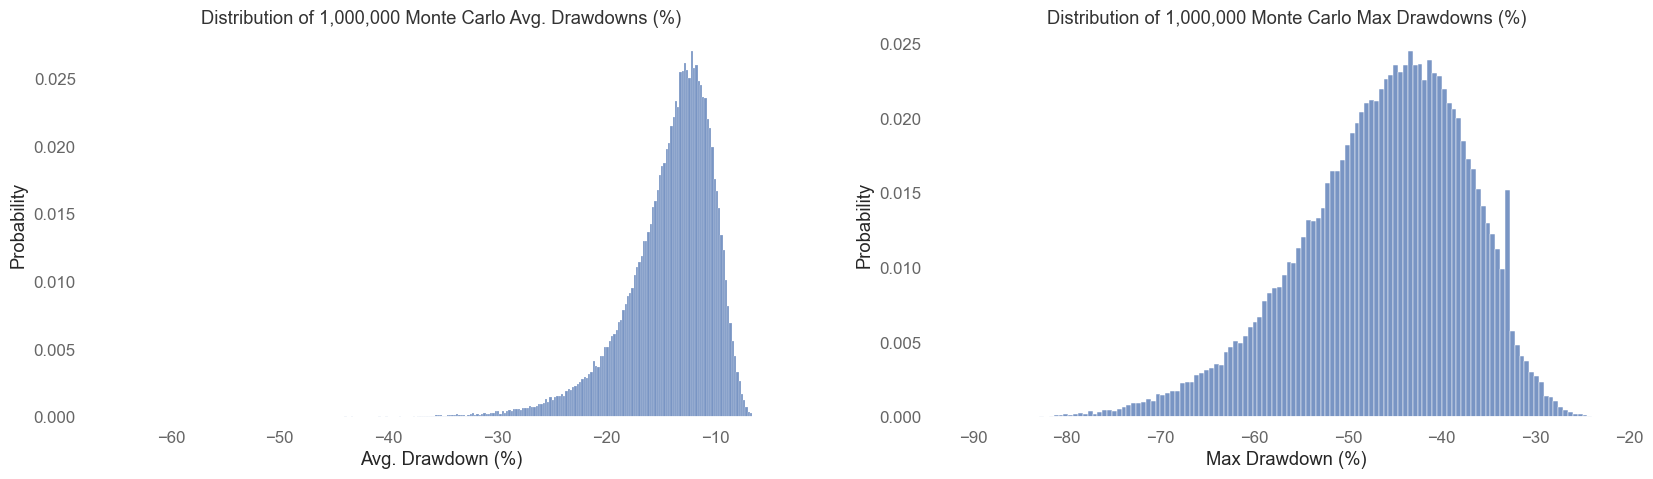

In [40]:
plot_bootstrapped_drawdowns(monte_carlo_risk_metrics = bb_metrics, N = N)